# Spiral Waveguide 

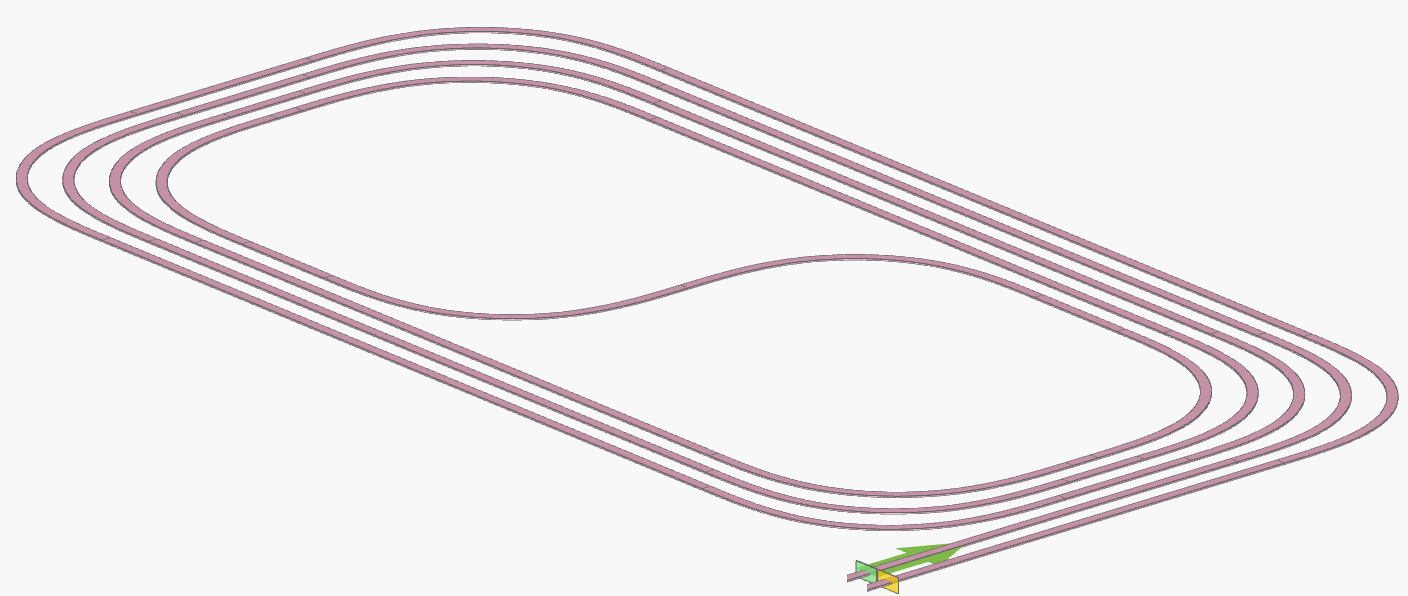

Simulating large photonic structures such as spirals using full-field electromagnetic methods like FDTD can be computationally expensive and time-consuming. This notebook demonstrates how we can efficiently simulate such devices using a **compact circuit model**, which leverages pre-characterized components—such as bends and straights—to drastically reduce simulation cost without compromising accuracy.

We begin by defining a custom silicon nitride (SiN) technology that includes both optical and electrical material properties, as well as port and layer specifications. We then construct a rectangular spiral waveguide with a total length of 5 mm and use a **circuit-level simulation approach** to compute its scattering matrix. The circuit model automatically performs one-time simulations for each unique waveguide element (e.g., a representative bend or straight) and assembles the global response based on their interconnections.

To validate the accuracy of the circuit model, we also define a **full Tidy3D FDTD model** for the spiral. While running this simulation is expensive, we provide a precomputed S-matrix file that users can download and use directly. This allows for a side-by-side comparison of the circuit and full-field results, highlighting the efficiency and effectiveness of the circuit-based approach for large passive photonic structures.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import photonforge as pf
import tidy3d as td
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer(port=5007)

Starting live viewer at http://localhost:5007


## Custom Silicon Nitride Technology

We begin by defining a custom silicon nitride (SiN) technology. 

In [2]:
_Medium = td.components.medium.MediumType


def sin_technology(
    sin_thickness=0.4,
    sio2: dict[str, _Medium] = {
        "optical": td.material_library["SiO2"]["Palik_Lossless"],
        "electrical": td.Medium(permittivity=4.2, name="SiO2"),
    },
    sin: dict[str, _Medium] = {
        "optical": td.material_library["Si3N4"]["Luke2015PMLStable"],
        "electrical": td.Medium(permittivity=7.5, name="Si3N4"),
    },
):
    """
    Creates a custom silicon nitride (SiN) technology for photonic circuit simulation.

    Parameters:
        sin_thickness (float): Thickness of the SiN core in microns.
        sio2 (dict[str, Medium]): Dictionary with 'optical' and 'electrical' properties for the SiO2 cladding.
        sin (dict[str, Medium]): Dictionary with 'optical' and 'electrical' properties for the SiN core.

    Returns:
        pf.Technology: A fully defined technology object for layout and simulation.
    """
    # Define the layer for the SiN waveguide
    layers = {
        "WG": pf.LayerSpec((0, 0), description="SiN", color="#6db5dd18", pattern="/")
    }

    # Define a mask at the base level for the SiN layer
    sin_mask = pf.MaskSpec((0, 0))

    # Extrude the mask vertically to form the waveguide core
    extrusion_specs = [
        pf.ExtrusionSpec(
            sin_mask, limits=(0, sin_thickness), medium=sin, sidewall_angle=0
        )
    ]

    # Define ports for a 3500 nm wide strip waveguide
    ports = {
        "Strip_3500": pf.PortSpec(
            description="Strip waveguide, TE, 3500 nm wide",
            width=10,
            limits=(-2.5, sin_thickness + 2.5),
            num_modes=1,
            target_neff=2,
            path_profiles=[(3.5, 0, (0, 0))],
        ),
    }

    # Assemble and return the full technology definition
    tech = pf.Technology(
        name="Custom SiN",
        version="1.0",
        layers=layers,
        extrusion_specs=extrusion_specs,
        ports=ports,
        background_medium=sio2,
    )
    return tech

Next, we initialize the custom SiN technology and set it as the default technology. To reduce simulation cost, especially for large structures like spirals, we also set a relatively coarse mesh refinement value.


In [3]:
# Instantiate the custom SiN technology
tech = sin_technology()

# Set it as the default technology for PhotonForge
pf.config.default_technology = tech

# Define default mesh refinement
pf.config.default_mesh_refinement = 14

# Define a range of wavelengths
wavelengths = np.linspace(1.5, 1.6, 51)
freqs = pf.C_0 / wavelengths

## Inspecting Port Modes

To improve the accuracy of the circuit model, we include the second-order mode by setting `num_modes = 2`. This is particularly important for large or tightly bent structures where higher-order modes may contribute significantly. We then visualize the mode to verify that the field is well confined and the mode shape and effective index are physically reasonable.


Loading cached simulation from /home/amin/.tidy3d/pf_cache/MDY/ms_info-UUVJWFEEONKJ2M57JXAVGVO3Y7Y5IPACIRKA7FQOULQKXUL4QEKQ.json.
Progress: 100%


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.733006    0.0          0.999870   
             1                 1.55  1.696169    0.0          0.999392   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.987044        0.880759   1.706345  
             1                 0.949150        0.885144   1.848523

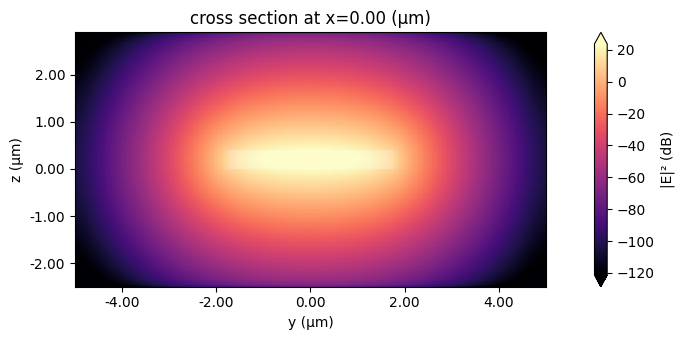

In [4]:
# Access the port specification for the 3500 nm wide strip
port_spec = tech.ports["Strip_3500"]

# Interaction with second mode should be included in circuit analysis
port_spec.num_modes = 2

# Solve for the port modes at a representative frequency (λ = 1.55 µm)
mode_solver = pf.port_modes(
    port_spec,
    frequencies=[pf.C_0 / 1.55],
    mesh_refinement=40,
)

# Plot the electric field magnitude (in dB) (change the mode_index to inspect different modes)
_, ax = plt.subplots(1, 1, figsize=(10, 3.5), tight_layout=True)
_ = mode_solver.plot_field("E", "abs^2", "dB", mode_index=0, f=pf.C_0 / 1.55, ax=ax)

# Output mode data as a DataFrame
mode_solver.data.to_dataframe()

## Spiral Simulation
### Creating a Spiral

We now create a rectangular spiral waveguide with a total length of 5000 µm using the [parametric.rectangular_spiral](../_autosummary/photonforge.parametric.rectangular_spiral.rst) function. The spiral is built from straight and bent waveguide segments, with 80 µm bend radius and 10.5 µm separation between waveguide centers. We also specify `Tidy3D` as the active bend model with an Euler bend profile. Finally, we visualize the spiral layout to verify its structure.


In [5]:
# Define total spiral length in microns
spiral_length = 5000

# Create the rectangular spiral geometry using the specified port and bend settings
spiral = pf.parametric.rectangular_spiral(
    port_spec=port_spec,
    radius=80,
    full_length=spiral_length,
    separation=10.5,
    align_ports="x",
    bend_kwargs={"active_model": "Tidy3D", "euler_fraction": 0.5},
)

# Visualize the spiral layout
viewer(spiral)

### Circuit Model Simulation

Instead of running a full electromagnetic simulation, we activate the compact circuit model for the spiral. This model automatically builds Tidy3D simulations for the bends and mode solver simulations for the straight segments to efficiently compute the individual scattering matrices over the defined frequency range. These are then combined to generate the final S-matrix for the entire structure.

Although the spiral contains many bends and straight segments, only **one simulation per unique component type** (e.g., a single representative bend or straight) is performed. This significantly reduces the overall simulation cost while maintaining accuracy in the circuit-level response. We simulate the response by exciting the input port `P0`.


In [6]:
# Activate the compact circuit model for the spiral
spiral.activate_model("Circuit")

# Compute the S-matrix over the given frequency range using circuit simulation
s_matrix_circuit = spiral.s_matrix(freqs, model_kwargs={"inputs": ["P0"]})

Loading cached simulation from /home/amin/.tidy3d/pf_cache/B2A/fdtd_info-6JFOFCHGEXDLPBYY7L6TWJKCHTS4LTBNA5M7UFLPBLFFZCVP4EMQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/B2A/fdtd_info-XCMDFI3IUSAWE2WMRCTZTEL6Y2CBMJCTOFJR7ZAFFNIU24MZSUHA.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/D4J/ms_info-OH3FEJLPVT5DCB6A4DRWBNSFVGDBUQZSGEI2VXSCKAPA5Z5BWZ5A.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/YI6/ms_info-D7CCKC5GBQ5ID42LBTVXZZRHL336MDSAXGGZBJ22UXDIK5BCADBA.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/2R4/ms_info-IXE2UWQBCMGAA2SPBKRRXSW3DQQMOKRVLL6WGCUV7FRINCD5TLLQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/RYO/fdtd_info-IQ6JYLKTOQ4GSJEEFI2QTUWNTNCVVQTNPQPT6O7MDDFKPSXZD26Q.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/RYO/fdtd_info-6HPK5RQY6LB4ZL3NSQFZKRBBN5YSZCXNEVF7ONDQDF5X7JKQMDQQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/MHB/ms_info-CWGJDOOOMFC

### Full Tidy3D Model

To benchmark the circuit model, we also define a full FDTD simulation using the Tidy3D model. Since multi-mode analysis is not necessary for the FDTD simulation, we reduce the number of modes at the ports to 1.

We expand the simulation bounds to ensure the spiral is not placed too close to the absorbing boundaries, which could affect accuracy. The simulation runtime is also increased to allow the wave sufficient time to propagate through the entire spiral structure.

It's important to note that this full-field simulation is **very computationally expensive**, especially for large structures like spirals, in contrast to the much more efficient circuit model. An estimate of the simulation cost is provided to quantify this overhead.


In [7]:
# Limit to single-mode analysis for FDTD simulation to reduce cost
spiral.ports["P0"].spec.num_modes = 1
spiral.ports["P1"].spec.num_modes = 1

# Get the physical bounds of the spiral structure
sim_bounds = spiral.bounds()

# Create a full Tidy3D model with expanded bounds and extended simulation time
tidy3dModel = pf.Tidy3DModel(
    bounds=(
        (sim_bounds[0][0] - 10, sim_bounds[0][1] - 10, None),
        (sim_bounds[1][0] + 10, sim_bounds[1][1] + 10, None),
    ),
    run_time=3 * spiral_length / pf.C_0 * mode_solver.data.n_eff[0][0].values,
)

# Add the Tidy3D model to the spiral
spiral.add_model(tidy3dModel, "Tidy3DModel")

# Estimate the cost of running the full FDTD simulation
estimated_cost = tidy3dModel.estimate_cost(spiral, freqs)

11:33:11 EDT Maximum FlexCredit cost: 4361.552 for the whole batch.

**(Optional) Running Full FDTD Simulation and Saving Results**

The following lines are commented out to avoid triggering a high-cost simulation by default. They compute the full S-matrix of the spiral using the Tidy3D model and save the results to a Touchstone file. Users can uncomment and run these lines if they wish to run full FDTD simulation model.


In [8]:
# s_matrix_tidy3d = spiral.s_matrix(freqs, model_kwargs={"inputs": ["P0"]})
# _ = s_matrix_tidy3d.write_snp("s_matrix_tidy3D_spiral.s2p")

### Loading Precomputed Tidy3D Results

To avoid the high cost of running a full Tidy3D simulation, you can download a ZIP archive of precomputed Touchstone files from the following link:

**[s_matrix_data](../examples/s_matrix_tidy3D_spiral.zip)**

Each file corresponds to a simulation with a different mesh refinement setting (grid specification). We load these S-matrices from file, wrap them in `DataModel` objects, and attach them to the spiral component for analysis.

Finally, we compare the transmission spectra obtained from the circuit model and the full Tidy3D simulations. All results are plotted in dB scale.

Due to the extreme physical size of the spiral structure, achieving high accuracy with full FDTD simulation is not practically feasible—especially with limited computational resources. However, the plot below demonstrates that as we increase the mesh refinement (grid 10 → 12 → 14), the Tidy3D results progressively converge toward the circuit model prediction. This highlights the **efficiency and reliability** of the compact circuit modeling approach for large photonic components.


Progress: 100% 
Progress: 100% 
Progress: 100% 


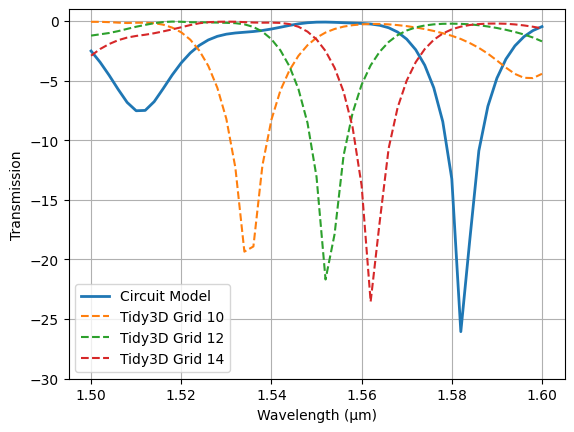

In [9]:
# Define the file names and grid labels for each Tidy3D result
snp_files = {
    "Grid 10": "s_matrix_tidy3D_spiral_grid10.s2p",
    "Grid 12": "s_matrix_tidy3D_spiral_grid12.s2p",
    "Grid 14": "s_matrix_tidy3D_spiral_grid14.s2p",
}

# Plot Circuit Model result
plt.plot(
    wavelengths,
    10 * np.log10(np.abs(s_matrix_circuit[("P0@0", "P1@0")]) ** 2),
    label="Circuit Model",
    linewidth=2,
)

# Plot each Tidy3D-based result
for label, file in snp_files.items():
    # Load the S-matrix from the Touchstone file
    s_matrix = pf.SMatrix.load_snp(file)

    # Wrap in a DataModel
    data_model = pf.DataModel(s_matrix)

    # Add and activate the model on the spiral component
    spiral.add_model(data_model, label)
    spiral.activate_model(label)

    # Get S-matrix at the given frequencies
    s_matrix_data = spiral.s_matrix(freqs, model_kwargs={"inputs": ["P0"]})

    # Plot transmission from P0 to P1
    plt.plot(
        wavelengths,
        10 * np.log10(np.abs(s_matrix_data[("P0@0", "P1@0")]) ** 2),
        label=f"Tidy3D {label}",
        linestyle="--",
    )

# Finalize the plot
plt.xlabel("Wavelength (µm)")
plt.ylabel("Transmission")
plt.ylim(-30, 1)
plt.legend()
plt.grid(True)
plt.show()